In [3]:
%load_ext autoreload
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
BASE_PATH = os.path.join(os.getcwd(), "..", "..")
MODULES_PATH = os.path.join(BASE_PATH, "modules")
METRICS_PATH = os.path.join(BASE_PATH, "metrics")
STAT_PATH = os.path.join(BASE_PATH, "stats", "local")

In [5]:
sys.path.append(MODULES_PATH)
sys.path.append(os.path.join(BASE_PATH, "tf_al"))

In [6]:
%autoreload 2
from tf_al import ExperimentSuitMetrics
from utils import MetricsTransformer, Frame, ExperimentFrame, FrameScores, Stats

In [8]:
dtypes = {
    "run": int,
    "iteration": int,
    "train_time": float,
    "eval_sparse_categorical_crossentropy": float,
    "eval_sparse_categorical_accuracy": float,
    "query_time": float,
    "labeled_pool_size": int,
    "unlabeled_pool_size": int,
    "method": str
}

In [9]:
base_experiment_path = os.path.join(METRICS_PATH, "cifar10_ios")
metrics_handler = ExperimentSuitMetrics(base_experiment_path)
df_mc = MetricsTransformer.load_from_dir(metrics_handler, "mc_dropout", dtype=dtypes)
scores = FrameScores(accuracy_column="eval_sparse_categorical_accuracy")
mc_frame = ExperimentFrame(df_mc, scores=scores)

/home/exleonem/.anaconda/envs/active_learning/lib/python3.8/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<AxesSubplot:xlabel='labeled_pool_size', ylabel='eval_sparse_categorical_accuracy'>

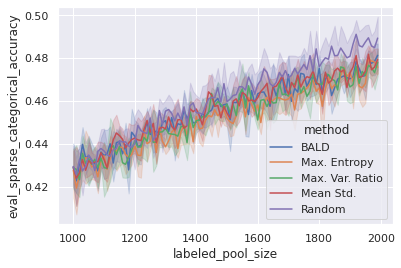

In [12]:
sns.lineplot(data=mc_frame.get_frame(), x="labeled_pool_size", y="eval_sparse_categorical_accuracy", hue="method")